In [1]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder

In [2]:
tf.random.set_seed(42)
tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [3]:
label_mapping = {
    **{i: "Speed_Limit" for i in range(0, 8)}, 
    **{i: "Dont_Go_Sign" for i in range(8, 15)},  
    **{i: "Go_Direction" for i in range(20, 25)},
    54: "No_Stopping", 
}

In [4]:
def map_label(class_id):
    return label_mapping.get(class_id, "Other_Signs")

In [5]:
def collect_data(folder_path, is_test=False):
    data = []
    if is_test:
        for filename in os.listdir(folder_path):
            if filename.endswith((".png", ".jpg")):
                class_id = int(filename.split('_')[0])  
                label = map_label(class_id)
                data.append([os.path.join(folder_path, filename), label])
    else:
        for class_id in os.listdir(folder_path):
            if class_id.isdigit():
                class_id = int(class_id)
                label = map_label(class_id)
                class_path = os.path.join(folder_path, str(class_id))
                for filename in os.listdir(class_path):
                    if filename.endswith((".png", ".jpg")):
                        data.append([os.path.join(class_path, filename), label])

    return data

In [6]:
train_data = collect_data('/kaggle/input/traffic-sign-dataset-classification/traffic_Data/DATA', is_test=False)
test_data = collect_data('/kaggle/input/traffic-sign-dataset-classification/traffic_Data/TEST', is_test=True)

In [7]:
train_df = pd.DataFrame(train_data, columns=['image_path', 'label'])
test_df = pd.DataFrame(test_data, columns=['image_path', 'label'])

In [8]:
train_df.to_csv('train_data.csv', index=False)
test_df.to_csv('test_data.csv', index=False)

In [9]:
def add_rain_effect(image, intensity=0.5):
    image = image.astype(np.uint8)
    height, width, channels = image.shape
    rain_layer = np.zeros((height, width, channels), dtype=np.uint8)
    
    num_drops = int(1500 * intensity)
    drop_size = (1, 5)
    drop_color = (200, 200, 200) 
    for _ in range(num_drops):
        x = np.random.randint(0, width)
        y = np.random.randint(0, height)
        length = np.random.randint(drop_size[0], drop_size[1])
        cv2.line(rain_layer, (x, y), (x, y + length), drop_color, 1)
    rain_layer = rain_layer.astype(image.dtype)

    return cv2.addWeighted(image, 1, rain_layer, intensity, 0)


In [10]:
def reduce_brightness(image, factor=0.3):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv[:, :, 2] = hsv[:, :, 2] * factor
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

In [11]:
def simulate_rainy_night(image, rain_intensity=0.3, brightness_factor=0.25):
    image = image.astype(np.uint8)
    rainy_image = add_rain_effect(image, intensity=rain_intensity)
    night_image = reduce_brightness(rainy_image, factor=brightness_factor)
    return night_image.astype(np.float32)
def normalize_image_for_display(image):
    return np.clip(image, 0, 255).astype(np.uint8)

In [12]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=10,
    zoom_range=0.2,
    preprocessing_function=simulate_rainy_night  
)

In [13]:
test_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=simulate_rainy_night  
)

In [14]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)

Found 4170 validated image filenames belonging to 5 classes.


In [15]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)

Found 1994 validated image filenames belonging to 5 classes.


In [16]:
label_encoder = LabelEncoder()
train_generator.classes = label_encoder.fit_transform(train_generator.classes)
test_generator.classes = label_encoder.transform(test_generator.classes)

In [17]:
def visualize_data_augmentation(dataframe, num_images=5):
    fig, axes = plt.subplots(num_images, 2, figsize=(12, num_images * 4))

    for i in range(num_images):
        original_img_path = dataframe.iloc[i]['image_path']
        original_img = cv2.imread(original_img_path)
        original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

        augmented_img = simulate_rainy_night(original_img_rgb)

        original_img_rgb = normalize_image_for_display(original_img_rgb)
        augmented_img = normalize_image_for_display(augmented_img)

        axes[i, 0].imshow(original_img_rgb)
        axes[i, 0].set_title(f"Original - {dataframe.iloc[i]['label']}")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(augmented_img)
        axes[i, 1].set_title(f"Augmented")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.savefig('data_augmentation_comparison.png')
    plt.show()

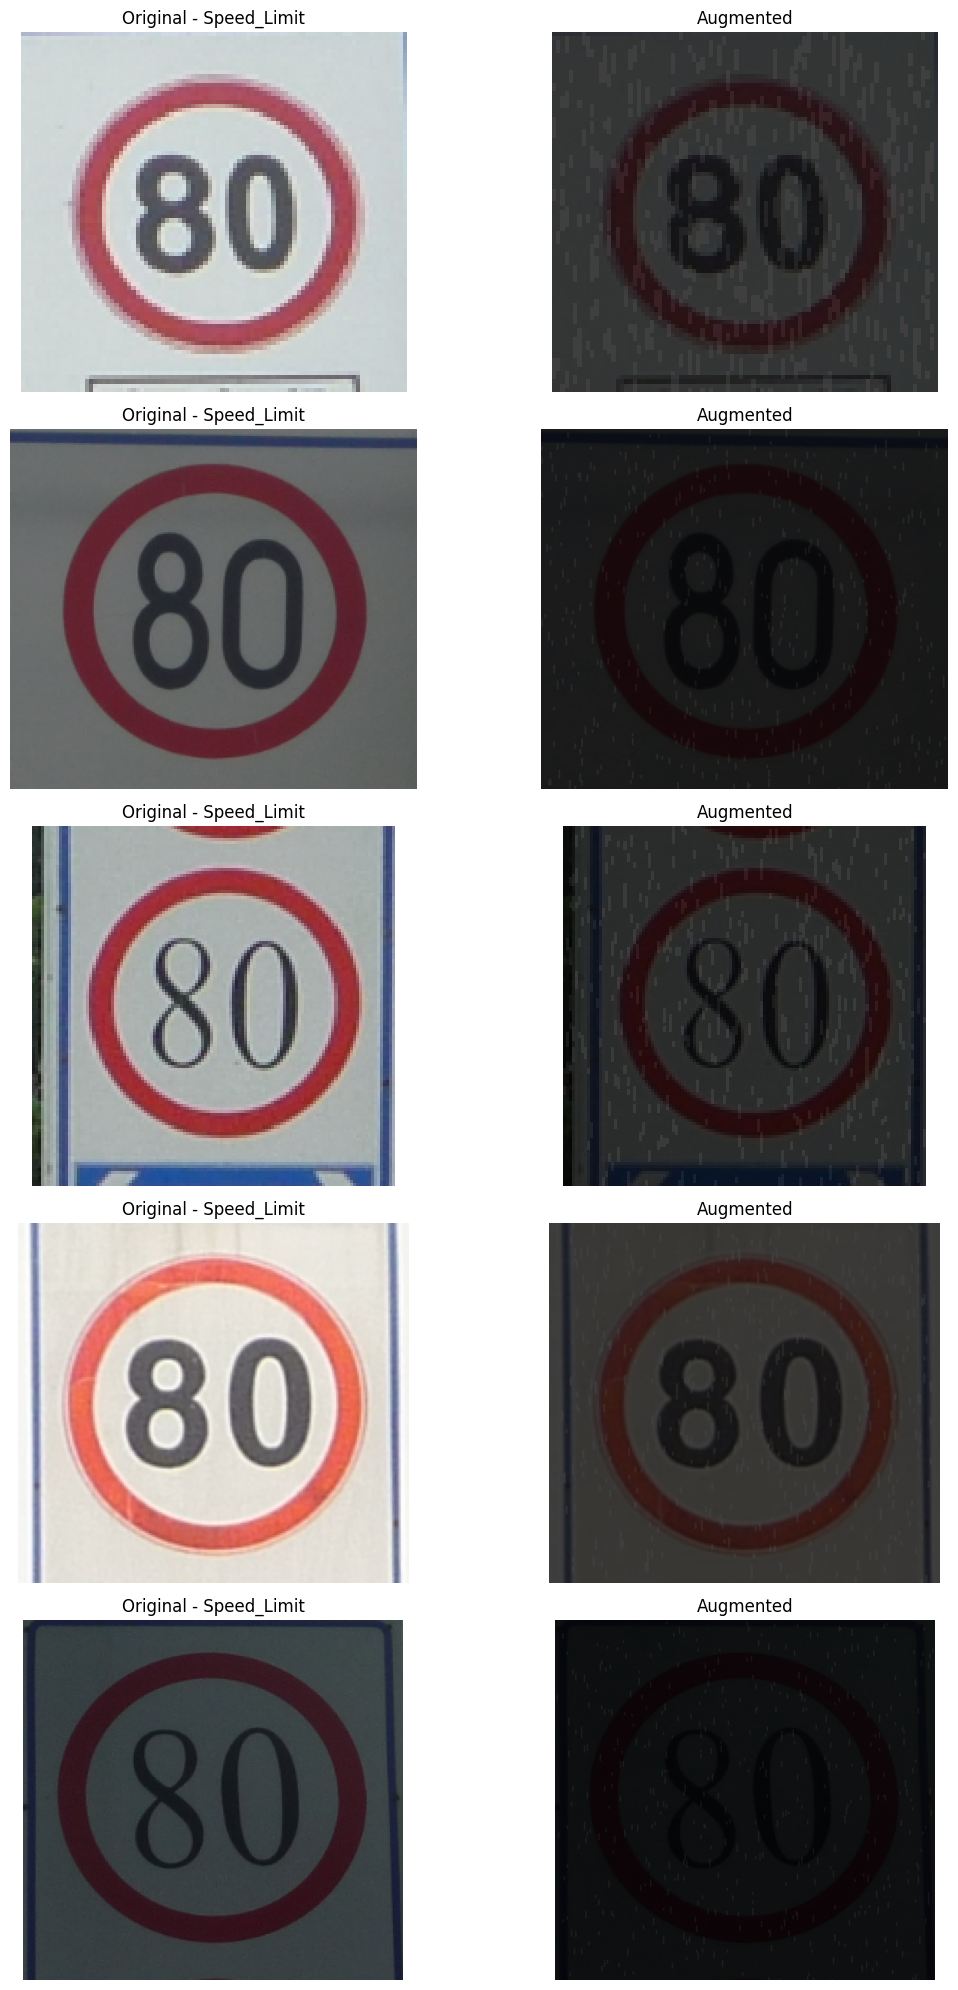

In [20]:
visualize_data_augmentation(train_df[10:26])

In [26]:
def build_efficientnetv2_lstm_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_tensor=inputs)
    base_model.trainable = True

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Reshape((1, -1))(x)
    x = layers.LSTM(128, return_sequences=True)(x)
    x = layers.LSTM(64)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.summary()
    return model

In [27]:
input_shape = (224, 224, 3)
num_classes = len(label_encoder.classes_)
model = build_efficientnetv2_lstm_model(input_shape, num_classes)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 56, 56,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 56, 56,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 56, 56,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 56, 56,    │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, 56, 56,    │          0 │ block2b_expand_b

 Total params: 6,699,093 (25.56 MB)

 Trainable params: 6,638,485 (25.32 MB)

 Non-trainable params: 60,608 (236.75 KB)

In [28]:
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5, verbose=1)

In [29]:
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=test_generator,
    callbacks=[checkpoint, reduce_lr]
)

Epoch 1/25


2024-09-22 01:37:32.588662: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_3_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


131/131 ━━━━━━━━━━━━━━━━━━━━ 171s 866ms/step - accuracy: 0.7776 - loss: 0.7628 - val_accuracy: 0.5376 - val_loss: 1.4669 - learning_rate: 0.0010
Epoch 2/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 111s 816ms/step - accuracy: 0.9577 - loss: 0.1478 - val_accuracy: 0.5376 - val_loss: 1.4191 - learning_rate: 0.0010
Epoch 3/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 111s 811ms/step - accuracy: 0.9813 - loss: 0.0805 - val_accuracy: 0.1655 - val_loss: 1.8421 - learning_rate: 0.0010
Epoch 4/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 111s 812ms/step - accuracy: 0.9827 - loss: 0.0683 - val_accuracy: 0.5326 - val_loss: 1.4195 - learning_rate: 0.0010
Epoch 5/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 111s 809ms/step - accuracy: 0.9938 - loss: 0.0264 - val_accuracy: 0.3250 - val_loss: 1.4118 - learning_rate: 0.0010
Epoch 6/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 111s 811ms/step - accuracy: 0.9908 - loss: 0.0426 - val_accuracy: 0.0988 - val_loss: 1.6778 - learning_rate: 0.0010
Epoch 7/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 111s 809ms/step - accuracy: 0.9810 

In [31]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Val Accuracy')
    ax1.set_title('Training and Validation Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Val Loss')
    ax2.set_title('Training and Validation Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

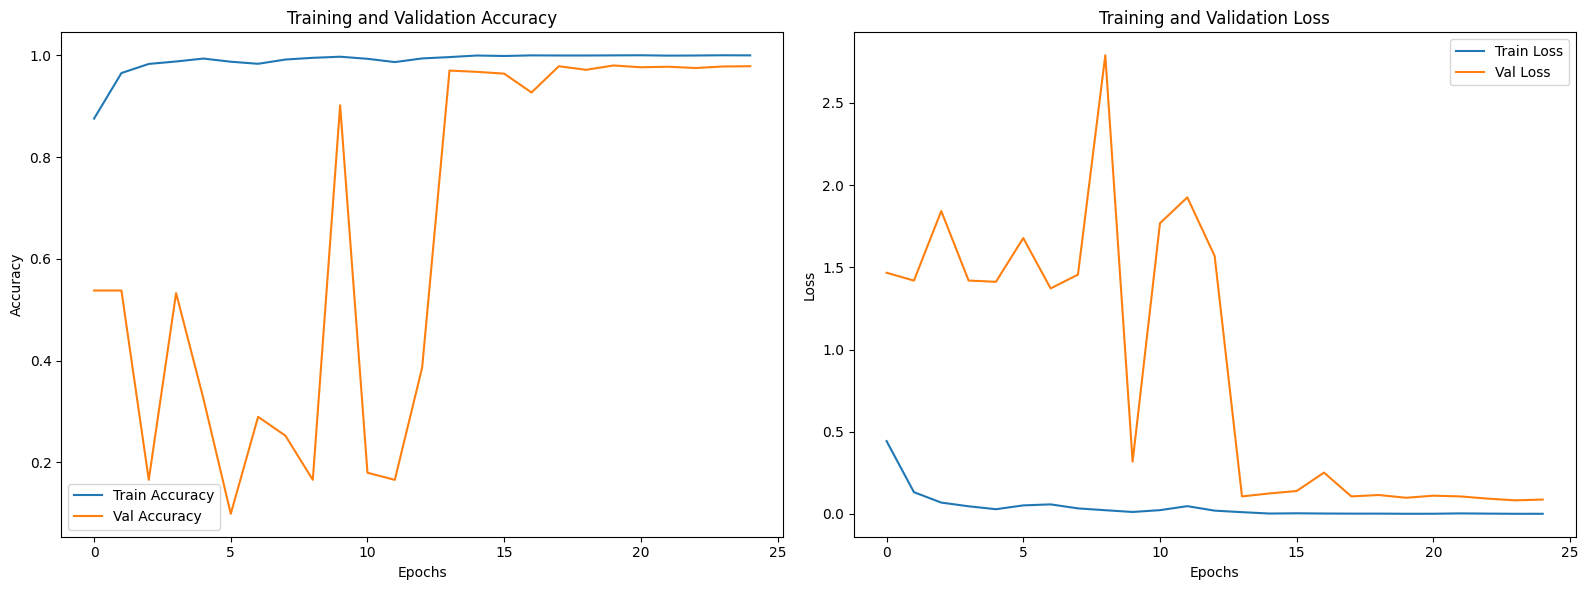

In [32]:
# Call the function to plot training history
plot_training_history(history)

In [33]:
model.load_weights('best_model.keras')
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 346ms/step - accuracy: 0.9786 - loss: 0.1115
Test Accuracy: 0.98


In [34]:
def plot_predictions(generator, model, num_images=5):
    images, labels = next(generator)
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)

    fig, axes = plt.subplots(num_images, 1, figsize=(8, num_images * 3))
    for i in range(num_images):
        axes[i].imshow(images[i])
        axes[i].set_title(f"True: {labels[i]}, Pred: {predicted_labels[i]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.savefig('predictions.png')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


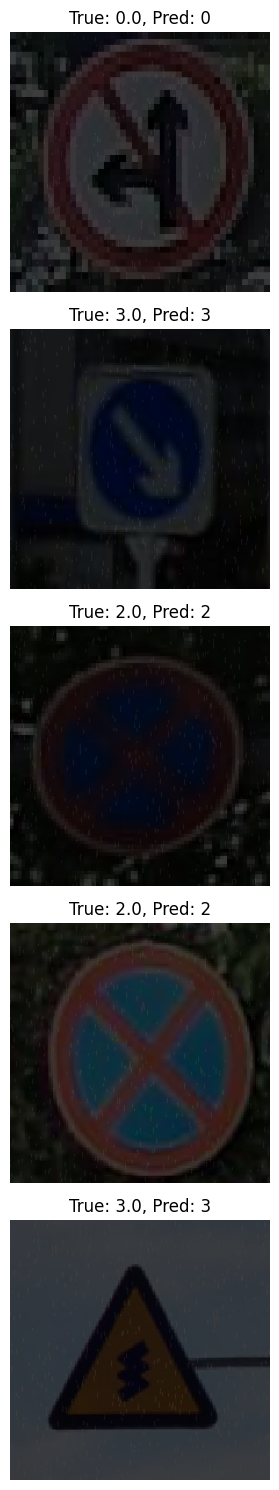

In [35]:
plot_predictions(test_generator, model)